In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing,svm
from sklearn.model_selection import  train_test_split, cross_validate
from sklearn.linear_model import Lasso, SGDRegressor, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
sns.set()

Загрузка данных первого сета.

In [3]:
abalone = pd.read_csv('abalone.data',names=["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"])
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [4]:
abalone.head(100)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
95,M,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,14
96,M,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,9
97,M,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,8
98,M,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,7


In [5]:
abalone[abalone['Sex']=="M"]['Sex'] = 1
abalone[abalone['Sex']=="F"]['Sex'] = -1
abalone[abalone['Sex']=="I"]['Sex'] = 0

C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Monya\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [6]:
abalone.count()

Sex               4177
Length            4177
Diameter          4177
Height            4177
Whole weight      4177
Shucked weight    4177
Viscera weight    4177
Shell weight      4177
Rings             4177
dtype: int64

В процентном соотношении.

In [7]:
for col in abalone.columns:
    pct_missing = np.mean(abalone[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {abalone[col].min()}     max:{abalone[col].max()}')

Sex - 0.0     min: F     max:M
Length - 0.0     min: 0.075     max:0.815
Diameter - 0.0     min: 0.055     max:0.65
Height - 0.0     min: 0.0     max:1.13
Whole weight - 0.0     min: 0.002     max:2.8255
Shucked weight - 0.0     min: 0.001     max:1.4880000000000002
Viscera weight - 0.0     min: 0.0005     max:0.76
Shell weight - 0.0     min: 0.0015     max:1.005
Rings - 0.0     min: 1     max:29


Пропущенных значений нет, как и заявлялось в описании. Странность есть в минимальном значении столбца "chlorides", исправим:

In [8]:
abalone["Shucked weight"] = round(abalone["Shucked weight"], 3)

In [9]:
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359363,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221969,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Из таблицы резко выбиваются значения "free sulfur dioxide":289 и "total sulfur dioxide": 400. Проверим не ошибочные ли это данные.

<AxesSubplot:xlabel='Sex', ylabel='Height'>

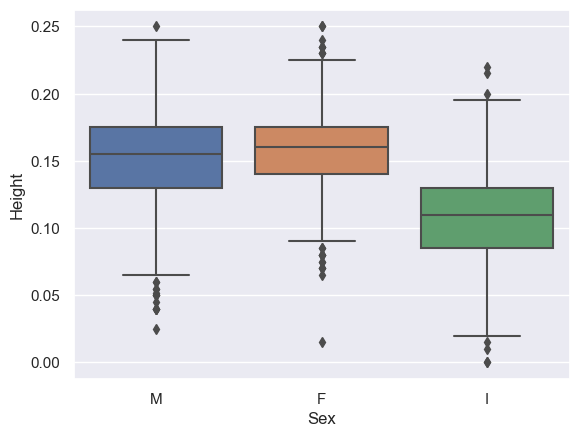

In [23]:
sns.boxplot(x="Sex", y="Height", data=abalone)

In [21]:
abalone[abalone["Height"]>0.5]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1417,M,0.705,0.565,0.515,2.21,1.108,0.4865,0.512,10


In [22]:
abalone['Height'] = np.where((abalone['Height'] > 0.5), abalone["Height"]/10,abalone["Height"])

Можно предположить что значение столбца "free sulfur dioxide" значением около 300 может быть ошибочным, как и значение "total sulfur dioxide" более 400. Посмотрим на эти записи ближе.

In [13]:
wines[wines["free sulfur dioxide"] > 200]

NameError: name 'wines' is not defined

Как видно это оказывается одна запись. И хоть это и выбросы  но их объяснение просто: сверх высокая кислотность привод к минимальной оценке. Эти данные не являются ошибочными.

In [ ]:
# sns.pairplot(wines);

In [ ]:
# corr_matrix = wines.corr()
# sns.heatmap(corr_matrix);

На таблицах корреляции, видно интересную картину, во первых корреляция присутствует в столбцах отвечающих за "кислость" вина, в принципе это не удивительно, чем больше сахара тем меньше кислости, и наоборот. Но есть один параметр напрямую коррелирующий с оценкой от экспертов, этот столбец "alcohol".

Добавим столбцы долей зависимых величин.

In [ ]:
wines["free sulfur dioxide share"] = round((wines["free sulfur dioxide"] / wines["total sulfur dioxide"]) * 100)
wines["volatile acidity share"] = round((wines["volatile acidity"] / wines["fixed acidity"]) * 100)

Применим самый простой скалер Min-max.

In [ ]:
scaler = preprocessing.MinMaxScaler()

target = wines["quality"]
wines.drop(columns=["quality"],inplace=True)

columns = wines.columns
wines[columns] = scaler.fit_transform(wines[columns])

Разделим наш датасет на 3 составляющие тренировочную, валидационную и тестовую.

In [ ]:
datasets= {"train":{},"validation":{},"test":{}}
datasets["train"]["data"], test_val_data, datasets["train"]["target"], test_val_target = train_test_split(wines, target, train_size=0.769585962753, shuffle=True)
datasets["test"]["data"], datasets["validation"]["data"], datasets["test"]["target"], datasets["validation"]["target"] = train_test_split(test_val_data, test_val_target, test_size=0.668002672011, shuffle=True)

Предоставим нашим 4 моделям тестовые данные, пусть работают.

In [ ]:
sgd = SGDRegressor()
sgd.fit(datasets["train"]["data"],datasets["train"]["target"])
lasso = Lasso()
lasso.fit(datasets["train"]["data"],datasets["train"]["target"])
ridge = Ridge()
ridge.fit(datasets["train"]["data"],datasets["train"]["target"])
linear = LinearRegression()
linear.fit(datasets["train"]["data"],datasets["train"]["target"])

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [ ]:
predictions = sgd.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
cv_sgd = cross_validate(lasso,datasets["train"]["data"],datasets["train"]["target"])
print("RMSE for sgd: {}".format(np.sqrt(mse)))
predictions = lasso.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("RMSE for lasso: {}".format(np.sqrt(mse)))
predictions = ridge.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("RMSE for ridge: {}".format(np.sqrt(mse)))
predictions = linear.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("RMSE for linear: {}".format(np.sqrt(mse)))

Как видно лучше всего справляется модель Lasso, её и возьмём за основу.

In [ ]:
lasso = Lasso(max_iter=5000,selection="cyclic",alpha=3,positive=True)
lasso.fit(datasets["train"]["data"],datasets["train"]["target"])
predictions = lasso.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

Посмотрим какая ошибка будет на тестовой части данных.

In [ ]:
predictions = lasso.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

(Если я не ошибаюсь) Процент правильности предсказания лежит где-то между 85-90%, нас это удовлетворяет.

Попробуем прогнать нашу же модель Lasso через подборку лучших гиперпараметров.

In [ ]:
parameters = {"alpha":[0.1,0.2,0.3,0.4],"max_iter":[1000,2000,3000,4000,5000],"warm_start":[True,False],"positive":[True,False],"selection":["cyclic","random"]}
clf = GridSearchCV(Lasso(), parameters)
clf.fit(datasets["train"]["data"],datasets["train"]["target"])

In [ ]:
predictions = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("RMSE: {}".format(np.sqrt(mse)))

Для меня лично удивительно что показатели не изменились, но значит или я что-то сделал не так, или модель мало восприимчива к имениям параметров. Точность так же осталась в пределах 85-90% что довольно высокий показатель. Мне кажется что не последнюю роль в таких результатах сыграла прямая корреляция столбца alcohol напрямую на таргет, из-за чего модель может предположить только по этому параметру оценку, и уже из двух соседних оценок выбрать на основе всех остальных столбцов.